In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# Check the availability of GPU

In [5]:
torch.cuda.is_available()

True

# Use GPU as a device for Training and Testing

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Mount the drive and set the path

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Neural Networks for Classification

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Neural Networks for Classification


# Import the dataset

In [7]:
import pandas as pd

data = pd.read_csv('mnist_train.csv')

In [8]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data.shape

(60000, 785)

# Transforming the data into Numpy array and Extracting only 10000 samples

In [10]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples

# Extracting Features and Labels

In [11]:
X = data[:,1:]
y = data[:,0]

In [12]:
X.shape

(10000, 784)

# Four Important steps to use data in Pytorch

In [13]:
# Step 1: Convert to pytorch tensor
X_t   = torch.tensor( X, dtype = torch.float32 )
y_t = torch.tensor( y, dtype = torch.long)

# Step 2: Perform Train Test Split and Normalize the data
train_data, test_data, train_labels, test_labels = train_test_split(X_t, y_t, test_size = 0.1)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)


# Step 3: Convert into PyTorch Datasets
X_train = TensorDataset(train_data,train_labels)
X_test  = TensorDataset(test_data,test_labels)


# Step 4: Move the data into dataloader objects
batchsize    = 32
train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader  = DataLoader(X_test, batch_size = X_test.tensors[0].shape[0])

In [14]:
9000/32

281.25

In [15]:
281*32

8992

In [16]:
X_test.tensors[0].shape[0]

1000

In [17]:
for X,y in train_loader:
    break
X.shape

torch.Size([32, 784])

# Visualizing Few Samples

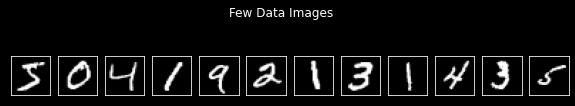

In [18]:
fig,axs = plt.subplots(1,12,figsize=(10,2))

for i in range(12):
  axs[i].imshow(X_t[i,:].view(28,28).detach() ,cmap='gray')
  axs[i].set_xticks([]), axs[i].set_yticks([])

plt.suptitle('Few Data Images')
plt.show()

# Create the Neural Network model

In [19]:
class NN_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(784,64)
    self.fc1 = nn.Linear(64,32)
    self.fc2 = nn.Linear(32,32)

    # Classification OR  output layer

    self.output = nn.Linear(32,10)

  # Forward pass

  def forward(self,x):

    # Pass the data through the input layer

    x = self.input(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)

    # output layer

    x = self.output(x)
    # X = torch.sigmoid
    return x

In [20]:
model = NN_Classifier()

# Train and Test the model

In [21]:
epochs = 101

lossfunc = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

# Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# For Loop for epochs

for epoch in range(epochs):
 model.train()

 # Loop for training in batches

 batchAcc  = []
 batchLoss = []

 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)

# Backpropagation

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.90
 epochs : 10  loss :  0.08
 epochs : 20  loss :  0.01
 epochs : 30  loss :  0.01
 epochs : 40  loss :  0.00
 epochs : 50  loss :  0.00
 epochs : 60  loss :  0.00
 epochs : 70  loss :  0.00
 epochs : 80  loss :  0.00
 epochs : 90  loss :  0.00
 epochs : 100  loss :  0.00


# Visualizing the Loss and Accuracies

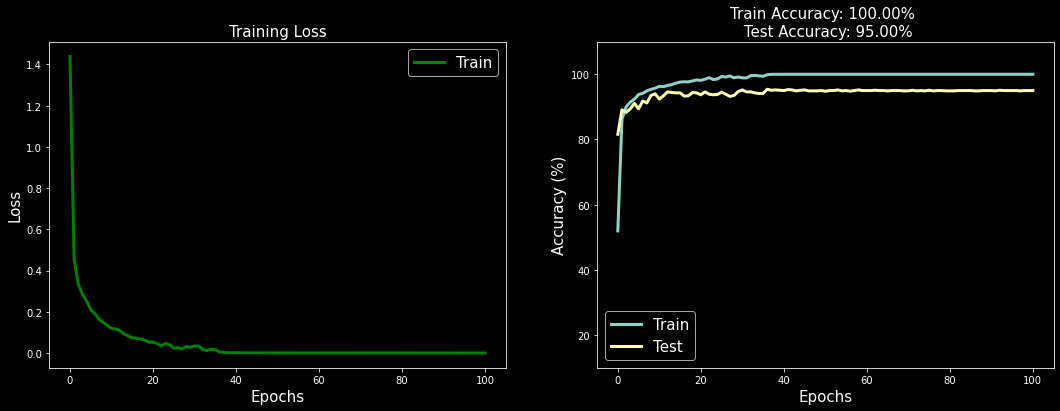

In [22]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [27]:
ypred = np.argmax(ypred, axis = 1)

# Create Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix,f1_score,precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

In [24]:
font = {
    'weight' : 'bold',
    'size'   : 15}
plt.rc('font', **font)

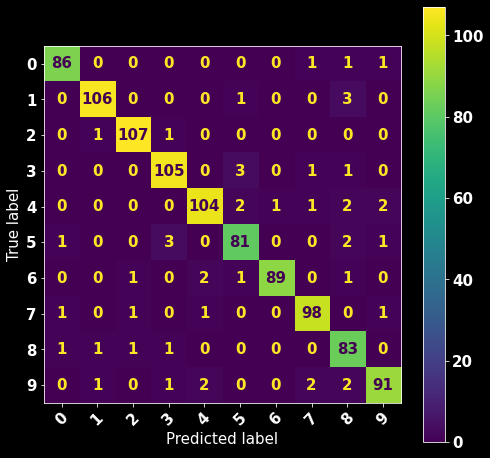

In [28]:
cm = confusion_matrix(ypred, y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0,1,2,3,4,5,6,7,8,9])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure() 
fig.set_figwidth(8)
fig.set_figheight(8) 
plt.show()

# Print Classification Report

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y, ypred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.96      0.97      0.97       109
           2       0.98      0.97      0.98       110
           3       0.95      0.95      0.95       111
           4       0.93      0.95      0.94       109
           5       0.92      0.92      0.92        88
           6       0.95      0.99      0.97        90
           7       0.96      0.95      0.96       103
           8       0.95      0.87      0.91        95
           9       0.92      0.95      0.93        96

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



# Save the Trained Model

In [23]:
# Save the model. The following line of code is saving the model  with its current state (weights and biases) in the
# dictionary, thats why the command state_dict(), with the name "My_TrainedModel.pt"

torch.save(model.state_dict(),'My_TrainedModel.pt')

#Load the Save Model

In [24]:
model.load_state_dict(torch.load('My_TrainedModel.pt'))

<All keys matched successfully>

# Test the Loaded Model

In [25]:
model.to(device)
X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

with torch.no_grad():
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

In [26]:
Acc = 100 * torch.mean((torch.argmax(ypred,dim=1)==y).float())
Acc

tensor(95.8000)

# OR

# Create the New Instance of the model

In [27]:
NewModel = NN_Classifier()

# Transfering Weights of the Trained model to new model

In [28]:
NewModel.load_state_dict(torch.load('My_TrainedModel.pt'))

<All keys matched successfully>

# Testing the new model

In [29]:
 NewModel.to(device)
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad():
  ypred_New = NewModel(X)
  ypred_New = ypred_New.cpu()
  y = y.cpu()


In [30]:
New_Acc = 100 * torch.mean((torch.argmax(ypred_New,dim=1)==y).float())
New_Acc

tensor(95.8000)